In [32]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from mgnn.MolGraphNetwork import MolGraphNetwork
from utils import find_repo_root
from scf_guess_tools import Backend
from scf_guess_datasets import Qm9IsomeresMd

project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)
BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
#Current best trial: ebffc_00023 with loss=3.290987253189087 and params={'batch_size': 16, 'hidden_dim': 512, 'message_passing_steps': 6, 'edge_threshold_val': 1., 'message_net_dropout': 0.09772288864576731, 'dat5122788896881607a_aug_factor': 1.0, 'message_net_layers': 5, 'lr': 0.0003257920597967229, 'weight_decay': 3.460137919135933e-06, 'num_epochs': 50, 'grace_epochs': 5, 'lr_factor': 0.5, 'lr_patience': 3, 'lr_threshold': 0.001, 'lr_cooldown': 2, 'lr_min': 1e-06}




Project root directory: /home/etschgi1/REPOS/Masterarbeit
Using device: cpu


In [33]:
local_pc_path = os.path.join(project_root_dir, "datasets/QM9") if str(device) != "cuda" else "/home/dmilacher/datasets/data1"
dataset = Qm9IsomeresMd(
    local_pc_path, 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1
)


In [34]:
MGNN = MolGraphNetwork(dataset=dataset,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=16,
                       hidden_dim=256,
                       message_net_layers=3,
                       message_passing_steps=4,
                       edge_threshold_val=3,
                       message_net_dropout=0.15,
                       target="density",
                       data_aug_factor=1,
                       verbose_level=2)
MGNN.load_data()

Setting verbose level to: 2
Loading 500 files from qm9_isomeres_md...
Loading 400 files for train set from /home/etschgi1/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres_md/xyz...
Loading 50 files for val set from /home/etschgi1/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres_md/xyz...
Loading 50 files for test set from /home/etschgi1/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres_md/xyz...


Creating training graphs: 400it [00:03, 121.94it/s]
Creating validation graphs: 50it [00:00, 69.27it/s] 
Creating test graphs: 50it [00:00, 61.61it/s]


Total samples: 500, Train: 400, Val: 50, Test: 50
Found 3 center keys (['C', 'H', 'O']) and 6 edge keys (['C_C', 'C_H', 'C_O', 'H_H', 'H_O', 'O_O']) in the training set. -> Totaling 9 unique encoder/decoder.
Normalization factors computed and applied.
Center stats: {'C': (0.08893045239638739, 0.2721039375810204), 'H': (0.3772194703420003, 0.4689655636092979), 'O': (0.08820201116919178, 0.2707920626400333)}, Edge stats: {'C_C': (0.0011379653564876178, 0.06569709775952803), 'C_H': (0.005914110449465438, 0.08904606448394098), 'C_O': (0.0005498404329203316, 0.05349375361419171), 'H_H': (0.015554158137366101, 0.062274110903945974), 'H_O': (0.0025328809647227227, 0.0531254159114207), 'O_O': (-0.00018409690548460062, 0.020875248930791054)}
First train batch: 304 atoms, 2586 edges, 304 center blocks.
Found center block size 351 for atom type O.
Found center block size 351 for atom type C.
Found center block size 15 for atom type H.
Found edge block size 676 for edge type C_O.
Found edge block 

In [35]:
RETRAIN = False  
model_name = "gnn_initial_MD_initial_isomer_train"
if not RETRAIN and os.path.exists(f"{project_root_dir}/3_studies/Block_guessing/6-31g_md_testing/models/{model_name}.pth"):
    MGNN.load_model(f"{project_root_dir}/3_studies/Block_guessing/6-31g_md_testing/models/{model_name}.pth")
else:
    MGNN.train_model(num_epochs=30, lr=0.00268, weight_decay=1.78e-05, grace_epochs=10, model_save_path=f"{project_root_dir}/3_studies/Block_guessing/6-31g_md_testing/models/{model_name}.pth", loss_on_full_matrix=False)
    MGNN.save_model(f"{project_root_dir}/3_studies/Block_guessing/6-31g_md_testing/models/{model_name}.pth")

Loaded weights from /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/6-31g_md_testing/models/gnn_initial_MD_initial_isomer_train.pth (strict=True)


/home/etschgi1/REPOS/Masterarbeit/3_studies/mgnn/MolGraphNetwork.py:1082: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=lambda sto

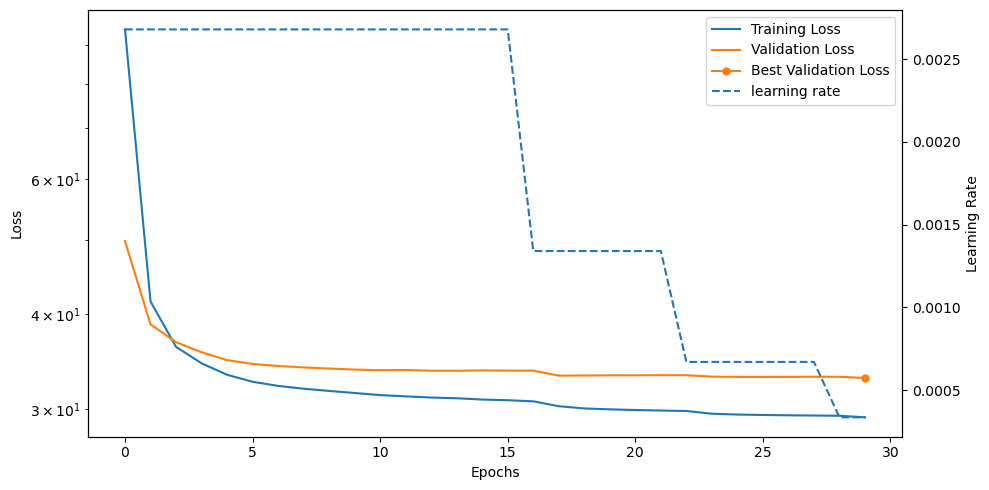

In [31]:
import pickle
from matplotlib import pyplot as plt
with open(f"{project_root_dir}/3_studies/Block_guessing/6-31g_md_testing/models/{model_name}.history", "rb") as f: 
    hist = pickle.load(f)
# hist["train_loss"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hist["train_loss"], label="Training Loss", color="tab:blue")
ax.plot(hist["val_loss"], label="Validation Loss", color="tab:orange")
ax.plot(np.array(hist["val_loss"]).argmin(), hist["val_loss"][np.array(hist["val_loss"]).argmin()],
         marker="o", markersize=5, color="tab:orange", label="Best Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax2 = ax.twinx()
ax2.plot(hist["lr"], linestyle="--", label="learning rate")
ax2.set_ylabel("Learning Rate")
ax2.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")
plt.tight_layout()
plt.show()

In [7]:
test_graphs = MGNN.get_graphs("test")

Testing on random sample with id 47


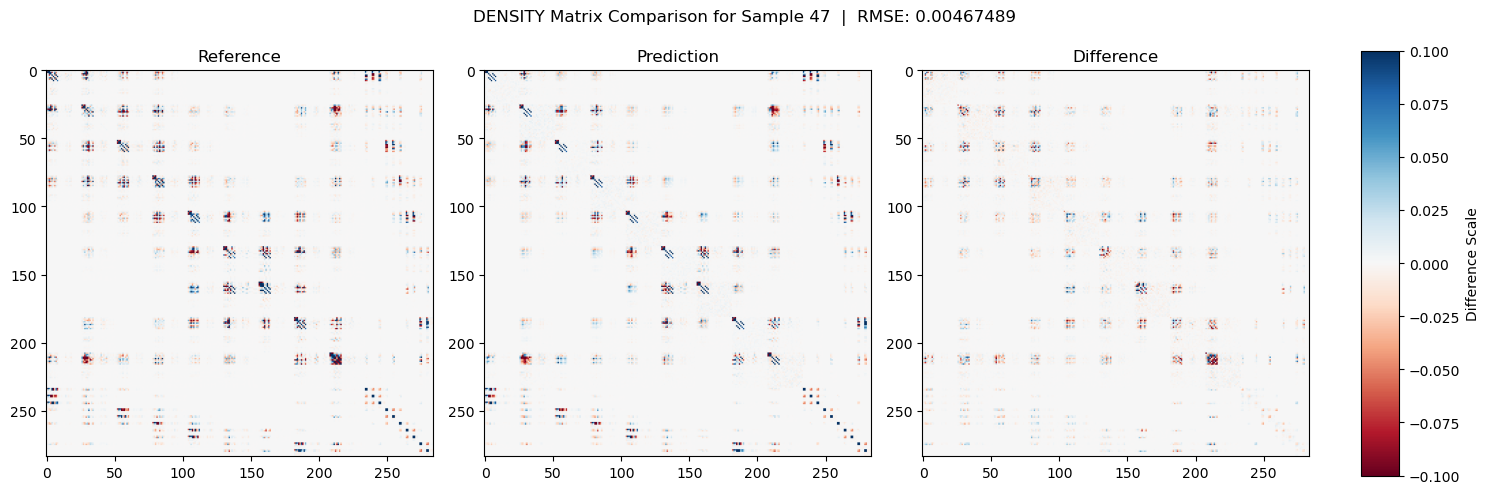

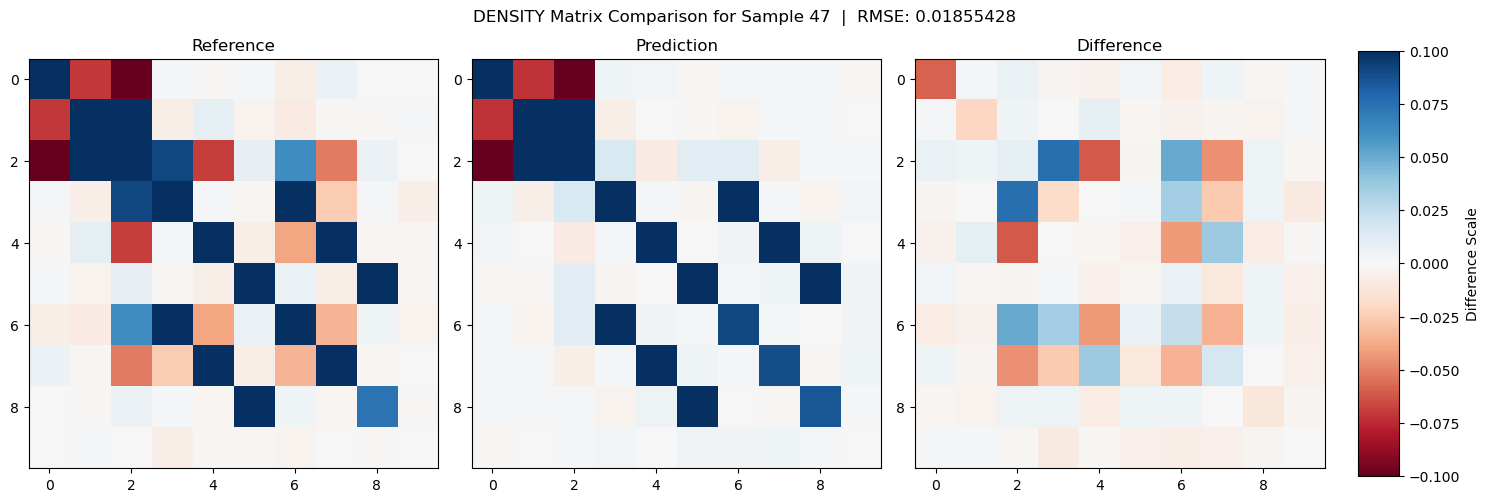

In [22]:
# aux code for testing
sys.path.append('../../')
from utils import plot_mat_comp

randsample_id = np.random.randint(0, len(test_graphs))
print(f"Testing on random sample with id {randsample_id}")
test_graph = test_graphs[randsample_id]
density_pred, density_truth = MGNN.predict([test_graph], include_target=True, transform_to_density=True)[0]
plot_mat_comp(density_truth, density_pred, 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)
plot_mat_comp(density_truth[:10,:10], density_pred[:10,:10], 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)

ok this already look pretty good for very few training runs!

In [ ]:
from scf_guess_tools import load, calculate, guess
from scipy.linalg import eigh
from pyscf import gto, scf

In [ ]:
# default calc using minao guess!
rand_file = MGNN.get_files("test")[randsample_id]
print(rand_file)
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_minao = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")

/home/etschgi1/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres_md/xyz/2144_1777.xyz
Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.098390034007


In [ ]:
density_pred = density_pred.astype(np.float64)

In [ ]:
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_own = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=density_pred)

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.108160685003


In [ ]:
# ground truth guess
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_gt = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=density_truth)

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.10816068506


In [ ]:
cycles_minao, cycles_own, cycles_gt = wf_minao.native.cycles, wf_own.native.cycles, wf_gt.native.cycles
print(f"Cycles with minao guess: {cycles_minao}, cycles with own guess: {cycles_own}, cycles with ground truth guess: {cycles_gt}")

Cycles with minao guess: 10, cycles with own guess: 13, cycles with ground truth guess: 13


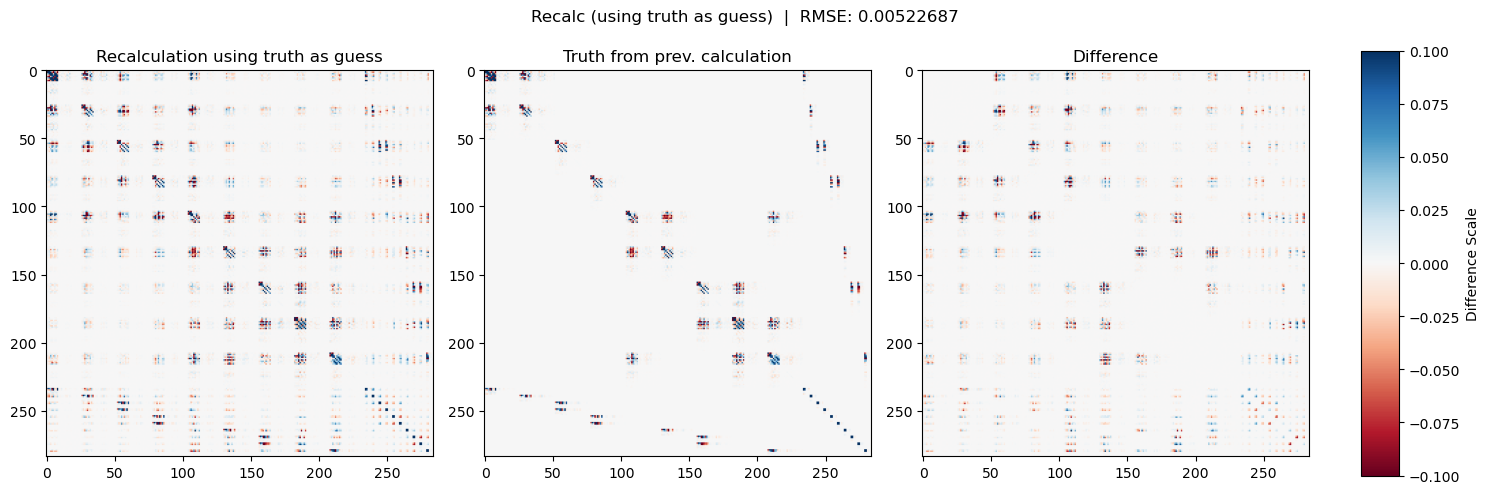

In [ ]:
plot_mat_comp(wf_minao._D, density_truth, title="Recalc (using truth as guess)", ref_title="Recalculation using truth as guess", pred_title="Truth from prev. calculation", vmax=0.1)

# Iteration Benchmark

In [36]:
from time import time
from uncertainties import ufloat
import scf_guess_datasets

In [37]:
start_time = time()
density_preds = MGNN.predict(test_graphs, include_target=False, transform_to_density=True)

pred_time = time() - start_time # stat benchmarking later
print(f"Prediction time for {len(test_graphs)} samples: {pred_time:.2f} seconds - {pred_time/len(test_graphs):.4f} seconds per sample")

files = MGNN.get_files("test")
print(f"Number of test files: {len(files)}")

cycles =  []
print("Testing for iteration count")

Prediction time for 50 samples: 2.66 seconds - 0.0531 seconds per sample
Number of test files: 50
Testing for iteration count


In [ ]:
# own 
test_keys = dataset.test_keys # only use half of the validation set -> which is the test set used by the model!
for i, density_pred in enumerate(density_preds):
    solver = dataset.solver(test_keys[i])
    overlap, hcore, density, fock, status = scf_guess_datasets.solve(solver, density_pred.astype(np.float64))
    cycles.append(status.iterations)
    print(f"Sample {i}: Cycles with own guess: {status.iterations} - {np.mean(cycles):.2f} mean cycles - {np.std(cycles):.2f} std cycles")


Sample 0: Cycles with own guess: 11 - 11.00 mean cycles - 0.00 std cycles
Sample 1: Cycles with own guess: 11 - 11.00 mean cycles - 0.00 std cycles
Sample 2: Cycles with own guess: 11 - 11.00 mean cycles - 0.00 std cycles
Sample 3: Cycles with own guess: 11 - 11.00 mean cycles - 0.00 std cycles
Sample 4: Cycles with own guess: 12 - 11.20 mean cycles - 0.40 std cycles
Sample 5: Cycles with own guess: 11 - 11.17 mean cycles - 0.37 std cycles
Sample 6: Cycles with own guess: 12 - 11.29 mean cycles - 0.45 std cycles
Sample 7: Cycles with own guess: 11 - 11.25 mean cycles - 0.43 std cycles


# Iterations benchmark

In [ ]:
import pickle
mean_own = np.mean(cycles)
std_own = np.std(cycles)
iter_own = ufloat(mean_own, std_own)
print(f"Average iterations with own guess: {iter_own:.2f}")
with open(f"{project_root_dir}/3_studies/Block_guessing/6-31g_md_testing/models/{model_name}_cycles.pkl", "wb") as f:
    pickle.dump(cycles, f)

Average iterations with own guess: 11.26+/-0.66


In [ ]:
scheme_iterations = {dataset.schemes[i]: [] for i in range(len(dataset.schemes))}
for key in dataset.test_keys: #! only use half of the validation set -> which is the test set used by the model!
    for scheme, sample in dataset.guesses(key).items():
        scheme_iterations[scheme].append(sample.status.iterations)
for scheme, iterations in scheme_iterations.items():
    print(f"{scheme}: {np.mean(iterations):.2f} +- {np.std(iterations):.2f} iterations")

1e: 18.24 +- 1.69 iterations
vsap: 14.46 +- 0.73 iterations
sap: 16.64 +- 1.77 iterations
minao: 10.74 +- 0.52 iterations


# Energy benchmark

In [ ]:
from pyscf import gto, dft

def create_mf_from_mol(mol: gto.Mole, xc: str = "b3lyp") -> dft.RKS:
    mf = dft.RKS(mol)
    mf.xc = xc
    mf.grids.build()  # ensures XC grid is initialized
    return mf

def build_fock_from_density(mf: dft.RKS, density):
    vj, vk = mf.get_jk(dm=density)
    vxc = mf.get_veff(mf.mol, dm=density)
    hcore = mf.get_hcore()
    return hcore + vj + vxc - 0.5 * vk
def energy_elec(fock, density, coreH): 
    return np.trace((fock+coreH) @ density)

def energy_err(e_pred, e_conv): 
    return e_conv - e_pred, e_pred/e_conv -1

In [ ]:
from scf_guess_datasets import solve


In [ ]:
# build all fock matrices
pred_focks = []
pred_overlaps = []
for i, pred_density in enumerate(density_preds):
    cur_mol = dataset.molecule(dataset.test_keys[i])
    mf = create_mf_from_mol(cur_mol, xc="b3lypg")
    pred_focks.append(build_fock_from_density(mf, pred_density))
    pred_overlaps.append(mf.get_ovlp())
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Energy error is expected to be very high if one compares this to conv sol!

In [ ]:
# dummy model
densities, focks, overlaps = [], [], []
for key in dataset.train_keys: 
    sample = dataset.solution(key)
    densities.append(sample.density)
    focks.append(sample.fock)
    overlaps.append(sample.overlap)
dummy_densities = np.mean(np.array(densities), axis=0)
dummy_focks = np.mean(np.array(focks), axis=0)
dummy_overlaps = np.mean(np.array(overlaps), axis=0)

In [ ]:
energy_metrics = {dataset.schemes[i]: {"energy_conv":[], "energy_guess":[], "abs_err":[], "rel_err":[]} for i in range(len(dataset.schemes))}
energy_metrics["own"] = {"energy_conv":[], "energy_guess":[], "abs_err":[], "rel_err":[]}
energy_metrics["dummy"] = {"energy_conv":[], "energy_guess":[], "abs_err":[], "rel_err":[]}
for own, key in zip((density_preds, pred_focks), dataset.test_keys): #! only use half of the validation set -> which is the test set used by the model!
    energy_conv = energy_elec(dataset.solution(key).fock, dataset.solution(key).density, dataset.solution(key).hcore)
    for scheme, sample in dataset.guesses(key).items():
        e_pred = energy_elec(sample.fock, sample.density, sample.hcore)
        err, rel_err = energy_err(e_pred, energy_conv)
        energy_metrics[scheme]["abs_err"].append(err)
        energy_metrics[scheme]["rel_err"].append(rel_err)
        energy_metrics[scheme]["energy_conv"].append(energy_conv)
        energy_metrics[scheme]["energy_guess"].append(e_pred)
    # own
    e_pred = energy_elec(own[1], own[0], sample.hcore)
    err, rel_err = energy_err(e_pred, energy_conv)
    energy_metrics["own"]["abs_err"].append(err)
    energy_metrics["own"]["rel_err"].append(rel_err)
    energy_metrics["own"]["energy_conv"].append(energy_conv)
    energy_metrics["own"]["energy_guess"].append(e_pred)
    # 0D
    e_pred = energy_elec(dummy_focks, dummy_densities, sample.hcore)
    err, rel_err = energy_err(e_pred, energy_conv)
    energy_metrics["dummy"]["abs_err"].append(err)
    energy_metrics["dummy"]["rel_err"].append(rel_err)
    energy_metrics["dummy"]["energy_conv"].append(energy_conv)
    energy_metrics["dummy"]["energy_guess"].append(e_pred)



for scheme, metrics in energy_metrics.items():
    abs_err = np.mean(metrics["abs_err"])
    rel_err = np.mean(metrics["rel_err"])
    print(scheme)
    print(f"{abs_err:.5f} +- {np.std(metrics['abs_err']):.5f}")
    print(f"{rel_err:.6f} +- {np.std(metrics['rel_err']):.6f}")
    # print(f"{scheme}: Mean Absolute Error: {abs_err:.6f}, Mean Relative Error: {rel_err:.6f}")
    # print(f"Energy Conv: {np.mean(metrics['energy_conv']):.6f}, Energy Guess: {np.mean(metrics['energy_guess']):.6f}")

1e
-229.07262 +- 5.07826
-0.129459 +- 0.001864
vsap
-5.89085 +- 0.21904
-0.003329 +- 0.000098
sap
-18.67523 +- 2.58255
-0.010567 +- 0.001542
minao
2.95970 +- 0.03734
0.001673 +- 0.000008
own
-8248.88407 +- 7962.18960
-4.627616 +- 4.464306
dummy
-202.79004 +- 2.69790
-0.114613 +- 0.000634


# DIIS Error

In [ ]:
def diis_rmse(overlap, density, fock): 
    """Eq 2.3 - Milacher"""
    E = fock @ density @ overlap - overlap @ density @ fock
    diis_rmse_ = np.sqrt(np.linalg.norm(E, ord='fro')**2 / (density.shape[0]**2))
    return diis_rmse_

In [ ]:
diis_metrics = {
    scheme: [] for scheme in dataset.schemes
}
diis_metrics["own"] = []  # for the own guess
diis_metrics["dummy"] = []  # for the dummy guess
diis_metrics["conv"] = []  # for the converged solution

for key in dataset.test_keys:  # only test split
    conv_diis = diis_rmse(dataset.solution(key).overlap, dataset.solution(key).density, dataset.solution(key).fock)
    diis_metrics["conv"].append(conv_diis)
    guesses = dataset.guesses(key)
    for scheme, sample in guesses.items():
        val = diis_rmse(sample.overlap, sample.density, sample.fock)
        diis_metrics[scheme].append(val)
    # own
    own_diis = diis_rmse(pred_overlaps[key - 450], density_preds[key - 450], pred_focks[key - 450])
    diis_metrics["own"].append(own_diis)
    # 0D
    dummy_diis = diis_rmse(dummy_overlaps, dummy_densities, dummy_focks)
    diis_metrics["dummy"].append(dummy_diis)


for scheme, values in diis_metrics.items():
    print(f"{scheme}: Mean DIIS RMSE: {np.mean(values):.10f} {np.std(values):.10f}")
    print(np.median(values))

1e: Mean DIIS RMSE: 0.1255406475 0.0083408498
0.12642838284579902
vsap: Mean DIIS RMSE: 0.0275657119 0.0021495052
0.028076943561315917
sap: Mean DIIS RMSE: 0.0468077179 0.0064737385
0.046974534580994876
minao: Mean DIIS RMSE: 0.0772359094 0.0033860032
0.07719191332544262
own: Mean DIIS RMSE: 0.2133634841 0.0153079308
0.2154827072648357
dummy: Mean DIIS RMSE: 0.0123185745 0.0000000000
0.01231857453342538
conv: Mean DIIS RMSE: 0.0000001612 0.0000000814
1.3451565028506498e-07


# RMSE

In [ ]:
rmse_metric = {
    scheme: [] for scheme in dataset.schemes
}
rmse_metric["own"] = []  # for the own guess
rmse_metric["dummy"] = []  # for the dummy guess

for key in dataset.test_keys:
    for scheme, sample in dataset.guesses(key).items():
        val = np.sqrt(np.mean((sample.density - dataset.solution(key).density)**2))
        rmse_metric[scheme].append(val)
    # own
    own_rmse = np.sqrt(np.mean((density_preds[key - 450] - dataset.solution(key).density)**2))
    rmse_metric["own"].append(own_rmse)
    # 0D
    dummy_rmse = np.sqrt(np.mean((dummy_densities - dataset.solution(key).density)**2))
    rmse_metric["dummy"].append(dummy_rmse)

for scheme, values in rmse_metric.items():
    print(f"{scheme}: Mean RMSE: {np.mean(values):.5f} {np.std(values):.5f}")


1e: Mean RMSE: 0.14053 0.02687
vsap: Mean RMSE: 0.01143 0.00061
sap: Mean RMSE: 0.01667 0.00158
minao: Mean RMSE: 0.01538 0.00018
own: Mean RMSE: 0.00769 0.00035
dummy: Mean RMSE: 0.01343 0.00029
